In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://open-api.coinglass.com/api/pro/v1/futures/vol/chart?symbol=BTC'
headers = {
  'coinglassSecret': 'a783e8583b66475cba597ab4e0bfeb24'
}
response = requests.request('get', url, headers=headers)
raw = response.json()

In [38]:
symbol = 'BTC'
url = f'https://open-api.coinglass.com/api/pro/v1/futures/funding_rates_chart?symbol={symbol}&type=U'
headers = {
  'coinglassSecret': 'a783e8583b66475cba597ab4e0bfeb24'
}
response = requests.request('get', url, headers=headers)
raw = response.json()

In [73]:
df = pd.DataFrame.from_dict(raw['data']['dateList'])
df.rename(columns={0: 'epoch'}, inplace=True)
df['epoch'] = df['epoch']/1000
df['epoch'] = df['epoch'].astype(int)
df['date'] = pd.to_datetime(df['epoch'], unit='s', utc=True)

In [74]:
df[f'price_{symbol.lower()}'] = raw['data']['priceList']

In [75]:
keys = list(raw['data']['dataMap'].keys())
keys_low = [x.lower() for x in keys]

for i in range(0, len(keys)):
    df[f'fr_{keys_low[i]}'] = raw['data']['dataMap'][keys[i]]

In [84]:
df.drop(542, inplace=True)

2.357535

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_17762/3395430010.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


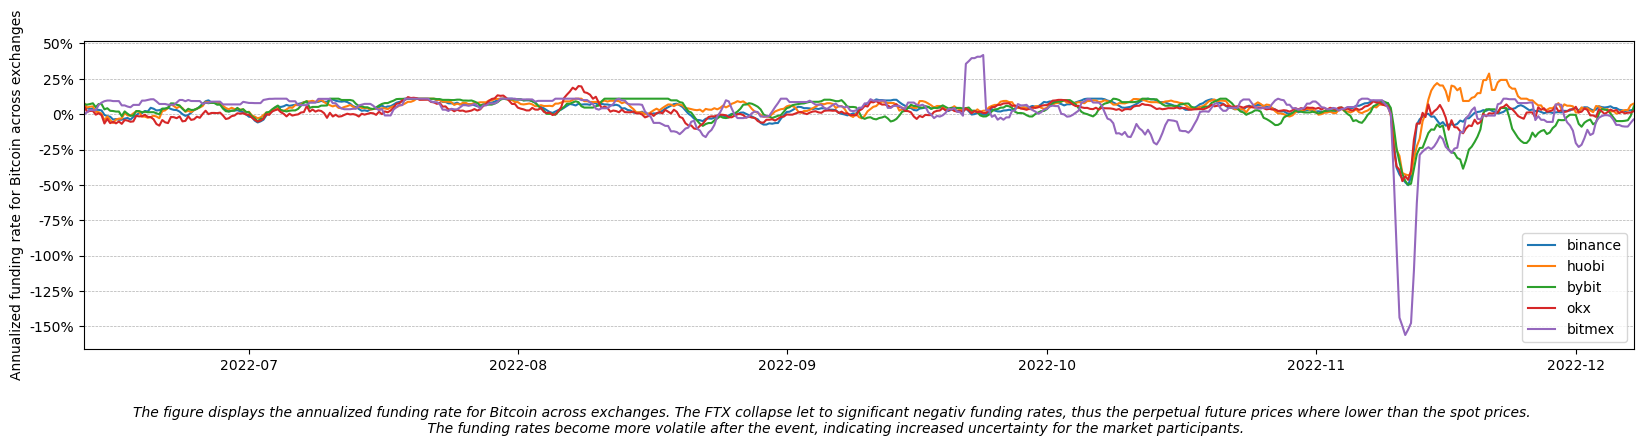

In [97]:
### take a look at the funding rate over time
fig, ax = plt.subplots(figsize =(20,4))

ax.plot(df['date'], (df['fr_binance']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)
ax.plot(df['date'], (df['fr_huobi']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)
ax.plot(df['date'], (df['fr_bybit']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)
ax.plot(df['date'], (df['fr_okx']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)
ax.plot(df['date'], (df['fr_bitmex']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)
#ax.plot(df['date'], (df['fr_coinex']*3*365/100).rolling(7, min_periods=1).mean(), linewidth=1.5)

ax.set_ylabel('Annualized funding rate for Bitcoin across exchanges')

left, right = plt.xlim()
ax.set_xlim(left+10, right-10)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.grid(axis='y', linestyle='--', linewidth=.5)

txt = 'The figure displays the annualized funding rate for Bitcoin across exchanges. The FTX collapse let to significant negativ funding rates, thus the perpetual future prices where lower than the spot prices. \n The funding rates become more volatile after the event, indicating increased uncertainty for the market participants.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

ax.legend(['binance', 'huobi', 'bybit', 'okx', 'bitmex', 'coinex'], loc='lower right')

plt.savefig(f'figures/exchange_fr.png')

plt.show()

## Volume

In [ ]:
response = requests.get(f'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=max&interval=daily')
price = response.json()


In [ ]:
df_price = pd.DataFrame(price['prices'], columns =['epoch', 'btc_price'])
df_price['epoch'] = df_price['epoch']/1000
df_price['epoch'] = df_price['epoch'].astype(int)
df_price['date'] = pd.to_datetime(df_price['epoch'], unit='s', utc=True)
df_price['btc_price'] = np.round(df_price['btc_price'], 2)
df_price = df_price[:-1]

In [ ]:
futures = ['binance_futures', 'hitbtc_derivatives', 'poloniex_futures', 'perpetual_protocol', 'huobi_dm', 'bitfinex_futures', 'bitforex_futures', 'kraken_futures', 'bitget_futures', 'okex_swap', 'mxc_futures', 'bybit', 'bingx_futures', 'kumex', 'gate_futures', 'bitmex', 'deribit', 'dydx_perpetual', 'crypto_com_futures']


In [ ]:
#raw_lst = []
for i in range(19, len(futures)):
    temp = futures[i]
    print(temp)
    try: 
        response = requests.get(f'https://api.coingecko.com/api/v3/exchanges/{temp}/volume_chart?days=1299')    
    except:
        print(temp, 'error')
        response = requests.get(f'https://api.coingecko.com/api/v3/exchanges/{temp}/volume_chart?days=1099')
        
    raw = response.json()
    raw = raw[1:]
    for t in range(0, len(raw)):
        raw[t][0] = int(raw[t][0])
        raw[t][1] = float(raw[t][1])+1

    raw_lst.append(raw)

In [ ]:
for j in range(0, len(raw_lst)):
    try: 
        number = raw_lst[j][-1][1]
        print(number*16000/1e6)
    except: KeyError: print(raw_lst[j])

response = requests.get(f'https://api.coingecko.com/api/v3/exchanges/{futures[10]}/volume_chart?days=1050')
raw = response.json()
raw_lst[10] = raw

In [ ]:
df = pd.DataFrame(raw_lst[0], columns =['epoch', f'volume_{futures[0]}'])
df['epoch']=df['epoch']/1000
df['epoch']=df['epoch'].astype(int)
df[f'volume_{futures[0]}']=df[f'volume_{futures[0]}'].astype(int)
df['epoch_rounded'] = df['epoch'] - (df['epoch'] % (60*60*24))
df

In [ ]:
for s in range(1,len(raw_lst)):
    df_temp = pd.DataFrame(raw_lst[s], columns =['epoch', f'volume_{futures[s]}'])
    df_temp['epoch']=df_temp['epoch']/1000
    df_temp['epoch']=df_temp['epoch'].astype(int)
    df_temp[f'volume_{futures[s]}']=df_temp[f'volume_{futures[s]}'].astype(int)
    df_temp['epoch_rounded'] = df_temp['epoch'] - (df_temp['epoch'] % (60*60*24))
    df = df.merge(df_temp[['epoch_rounded', f'volume_{futures[s]}']], how='left', on='epoch_rounded')


In [ ]:
df.drop(columns=['epoch'], inplace=True)
df.rename(columns={'epoch_rounded': 'epoch'}, inplace=True)

In [ ]:
df_price = df_price.merge(df, how='left', on='epoch')
df_price = df_price.fillna(0)

In [ ]:
for r in range(2,20):
    df_price[df_price.columns[r]] = (df_price['btc_price'] * df_price[df_price.columns[r]])/1e6

In [ ]:
df_price[df_price['sum'] > 500000]

In [ ]:
df_price['volume_binance_futures'] = (df_price['btc_price'] * df_price['volume_binance_futures'])/1e6

In [ ]:
df_price['sum']= df_price[df_price.columns[2:]].sum(axis='columns')

In [ ]:
df_price['date'] = pd.to_datetime(df_price['epoch'], unit='s', utc=True)

In [ ]:
df_price = df_price[df_price['date'] >= '2019-11-01']

In [ ]:
df = df_price

In [ ]:
df.drop(3228, inplace=True)
df.drop(3229, inplace=True)

In [ ]:
df.to_csv('data/volume_exchanges.csv', index=False)

In [ ]:
print('')
print('###Summary###')
print('median daily volume 2020: $', int(df[(df['date'] >= '2020') & (df['date'] < '2021')]['sum'].median()), 'million')
print('median daily volume 2021: $', int(df[(df['date'] >= '2021') & (df['date'] < '2022')]['sum'].median()), 'million')
print('median daily volume 2022: $', int(df[df['date'] >= '2022']['sum'].median()), 'million')
print('yearly volume 2020: $', int(df[(df['date'] >= '2020') & (df['date'] < '2021')]['sum'].sum()), 'million')
print('yearly volume 2021: $', int(df[(df['date'] >= '2021') & (df['date'] < '2022')]['sum'].sum()), 'million')
print('yearly volume 2022: $', int(df[df['date'] >= '2022']['sum'].sum()), 'million')
print('Binance dominance: ', min(df['volume_binance_futures']/df['sum']))

In [ ]:
### take a look at the funding rate over time
fig, ax = plt.subplots(figsize =(20,4))

ax.plot(df['date'], (df['sum']/1e3).rolling(3, min_periods=1).mean(), linewidth=1)

ax.set_ylabel('Daily traded volume ($ billion)')

left, right = plt.xlim()
ax.set_xlim(left+50, right-50)

txt = 'The figure displays the daily traded volume for perpetual futures across all exchanges. The median daily volume for 2021 is \$133.9bn. and for 2022 is \$126.5bn. \n This translates to a yearly volume of \$53,439bn. in 2021 and \$45,185bn. in 2022 respectively. We exclude exchanges which are known for misrepresenting data (e.g. washtrading).'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.savefig(f'figures/exchange_volume.png')

plt.show()